In [134]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from jpm_time_conversions import *
from jpm_logger import JpmLogger
import peakutils.peak
from closest import closest

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def light_curve_peak_match_subtract(light_curve_to_subtract_from_df, light_curve_to_subtract_with_df, estimated_time_of_peak,
                                    plots_save_path=None, verbose=False):
    """Align the peak of a second light curve to the first, scale its magnitude to match, and subtract it off.

    Inputs:
        light_curve_to_subtract_from_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex and a columns for intensity.
        light_curve_to_subtract_with_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex and a columns for intensity.
        estimated_time_of_peak [metatime]: The estimated time that the peak should occur. This could come from, e.g., GOES/XRS.
        
    Optional Inputs:
        plots_save_path [str]: Set to a path in order to save the validation curve and best fit overplot on the data to disk.
                               Default is None, meaning no plots will be saved to disk.
        verbose [bool]:        Set to log the processing messages to disk and console. Default is False.

    Outputs:
        light_curve_corrected_df [pd DataFrame]: A pandas DataFrame with the same format as light_curve_to_subtract_from_df but
                                                 with the resultant peak match and subtraction performed.
        seconds_shift [float]:                   The number of seconds that light_curve_to_subtract_with_df was shifted to get
                                                 its peak to match light_curve_to_subtract_from_df.
        rescale_factor [float]:                  The multiplicative factor applied to light_curve_to_subtract_with_df to get
                                                 its peak to match light_curve_to_subtract_from_df.
                                                 
    Optional Outputs:
        None

    Example:
        light_curve_corrected_df, seconds_shift, rescale_factor = light_curve_peak_match_subtract(light_curve_to_subtract_from_df, 
                                                                                                  light_curve_to_subtract_with_df,
                                                                                                  estimated_time_of_peak,
                                                                                                  plots_save_path='./',
                                                                                                  verbose=True)
    """
    return 1

In [187]:
# prototype only: set up example inputs
%matplotlib inline
estimated_time_of_peak = pd.Timestamp('2012-04-15 17:43:20.0')
plots_save_path = './'
verbose = True

from scipy.io.idl import readsav
idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Dimming Light Curve.sav')
light_curve_to_subtract_from_df = pd.DataFrame({'irradiance': np.nan_to_num(idl_generated_data.irradiance[:, 3])})
light_curve_to_subtract_with_df = pd.DataFrame({'irradiance': np.nan_to_num(idl_generated_data.irradiance[:, 10])})
light_curve_to_subtract_from_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
light_curve_to_subtract_with_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
light_curve_to_subtract_from_df.head()

,irradiance
2012-04-15 17:43:20,0.246831
2012-04-15 17:43:25,0.399922
2012-04-15 17:43:30,0.275836
2012-04-15 17:43:35,0.319487
2012-04-15 17:43:40,0.920058


In [231]:
# Detrend and find the peaks that are ≥ 95% of the max intensity within
base_from = peakutils.baseline(light_curve_to_subtract_from_df)
detrend_from = light_curve_to_subtract_from_df - base_from
indices_from = peakutils.indexes(detrend_from.values.squeeze(), thres=0.95)

base_with = peakutils.baseline(light_curve_to_subtract_with_df)
detrend_with = light_curve_to_subtract_with_df - base_with
indices_with = peakutils.indexes(light_curve_to_subtract_with_df.values.squeeze(), thres=0.95)

# Identify the peak closest to the input estimated peak time (e.g., from GOES/XRS)
peak_index_from = indices_from[closest(light_curve_to_subtract_from_df.index[indices_from], estimated_time_of_peak)]
peak_index_with = indices_with[closest(light_curve_to_subtract_with_df.index[indices_with], estimated_time_of_peak)]

# Compute how many seconds the time shift corresponds to
seconds_shift = (light_curve_to_subtract_from_df.index[peak_index_from] - 
                 light_curve_to_subtract_with_df.index[peak_index_with]).total_seconds()

In [238]:
light_curve_to_subtract_with_df.head()

,irradiance
2012-04-15 17:43:20,-0.253397
2012-04-15 17:43:25,-0.504447
2012-04-15 17:43:30,-0.337069
2012-04-15 17:43:35,-0.775113
2012-04-15 17:43:40,-0.665891


In [239]:
# Shift the light curve to subtract with in time to align the peaks
light_curve_to_subtract_with_df.shift(peak_index_from - peak_index_with).head()

,irradiance
2012-04-15 17:43:20,NaN
2012-04-15 17:43:25,-0.253397
2012-04-15 17:43:30,-0.504447
2012-04-15 17:43:35,-0.337069
2012-04-15 17:43:40,-0.775113


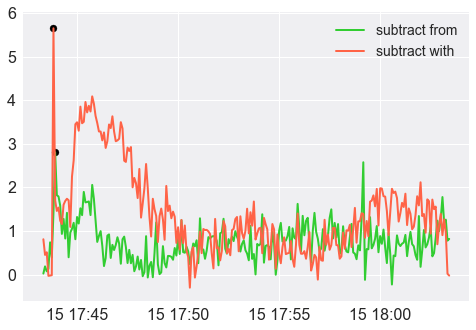

In [206]:
if plots_save_path:
    plt.style.use('jpm-light')
    plt.plot(detrend_from, c='limegreen', label='subtract from')
    plt.plot(detrend_with, c='tomato', label='subtract with')
    plt.legend(loc='best')
    plt.scatter(detrend_from.index[peak_index_from], detrend_from.values[peak_index_from], c='black')
    plt.scatter(detrend_with.index[peak_index_with], detrend_with.values[peak_index_with], c='black');